Import the needed libraries

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample


In [97]:
study_data = pd.read_csv("study_focus.csv")

print(study_data.shape)
print(study_data.columns)

(730, 7)
Index(['date', 'study_hours', 'focus_level', 'mood_score', 'sleep_hours',
       'journaling', 'social_interaction'],
      dtype='object')


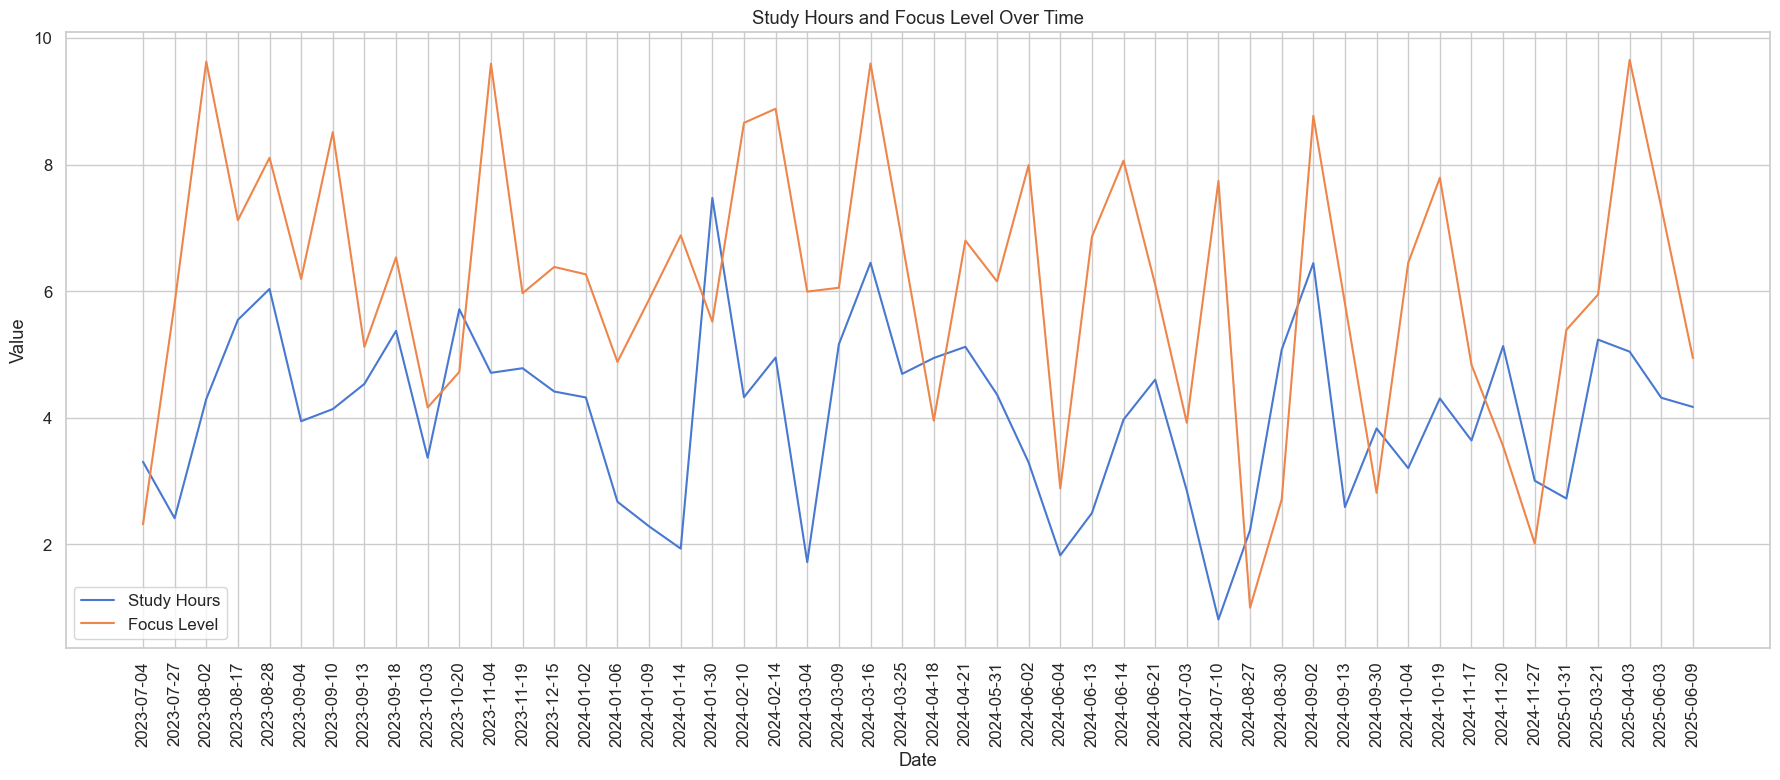

In [98]:
data_sample = study_data.sample(n= 50, random_state = 42)
data_sample = data_sample.sort_values(by = ['date'])

sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.figure(figsize=(18, 8))
sns.lineplot(x="date", y="study_hours", data=data_sample, label="Study Hours")
sns.lineplot(x="date", y="focus_level", data=data_sample, label="Focus Level")
plt.title("Study Hours and Focus Level Over Time")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

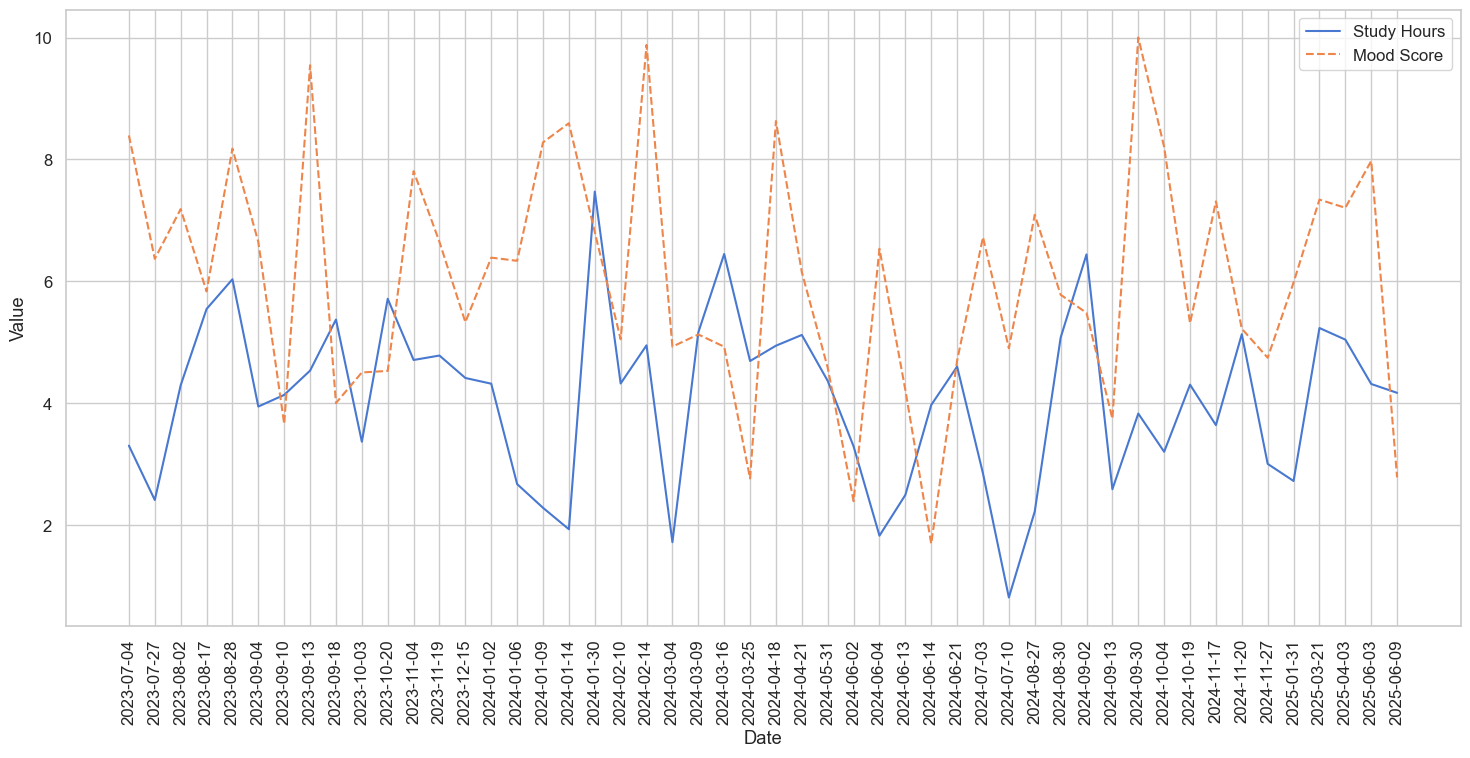

<Figure size 1800x800 with 0 Axes>

In [99]:
plt.figure(figsize=(18, 8))
sns.lineplot(x="date", y="study_hours", data=data_sample, label="Study Hours")
sns.lineplot(x="date", y="mood_score", data=data_sample, label="Mood Score", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.xticks(rotation=90)
plt.figure(figsize=(18, 8))
plt.tight_layout()
plt.show()

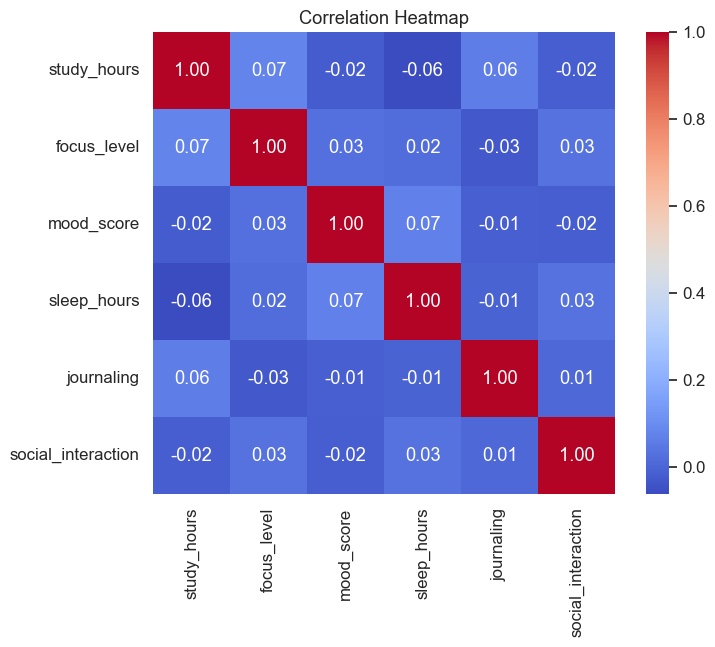

In [100]:
numeric_cols = ['study_hours', 'focus_level', 'mood_score', 'sleep_hours','journaling', 'social_interaction']
heatmap_data = study_data[numeric_cols]

corr = heatmap_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Heatmap")
plt.show()

In [101]:
# Select features for clustering
study_data["mood_x_sleep"] = study_data["mood_score"] * study_data["sleep_hours"]
study_data["study_efficiency"] = study_data["study_hours"] / (study_data["sleep_hours"] + 1)
features = ['study_hours', 'focus_level', 'mood_score', 'sleep_hours','journaling', 'social_interaction', 'mood_x_sleep', 'study_efficiency']

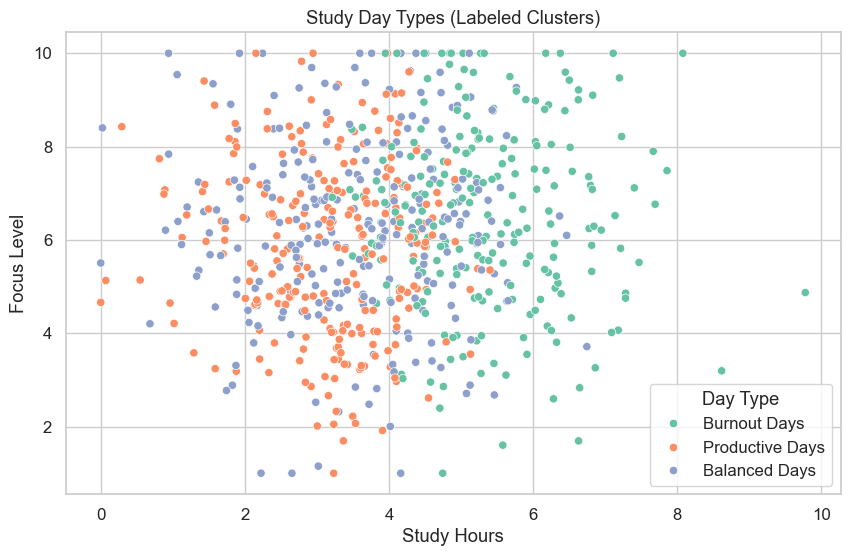

In [103]:
# Cluster labels
cluster_labels = {
    0: "Burnout Days",
    1: "Productive Days",
    2: "Balanced Days"
}

X = study_data[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Cluster into 3 types of days
kmeans = KMeans(n_clusters=3, random_state=42)
study_data["study_day_type"] = kmeans.fit_predict(X_scaled)
study_data["cluster_label"] = study_data["study_day_type"].map(cluster_labels)

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=study_data,
    x="study_hours",
    y="focus_level",
    hue="cluster_label",
    palette="Set2"
)
plt.title("Study Day Types (Labeled Clusters)")
plt.xlabel("Study Hours")
plt.ylabel("Focus Level")
plt.legend(title="Day Type")
plt.show()

In [118]:
def balance_focus_classes_loose(df, target_col='focus_bin', ratio=1.5):
    # Count each class
    counts = df[target_col].value_counts()
    min_count = counts.min()

    balanced_parts = []
    for cls in counts.index:
        n_samples = int(min_count * ratio) if cls == counts.idxmax() else min_count
        cls_samples = df[df[target_col] == cls]
        if len(cls_samples) > n_samples:
            cls_samples = cls_samples.sample(n=n_samples, random_state=42)
        balanced_parts.append(cls_samples)
    balanced_df = pd.concat(balanced_parts).sample(frac=1, random_state=42).reset_index(drop=True)
    return balanced_df

In [123]:
# -- Step 1: Define original bins (light imbalance)
def label_focus(val):
    return "Low" if val < 4.5 else "High"

study_data["focus_bin"] = study_data["focus_level"].apply(label_focus)

# -- Step 2: Create interaction term
balanced_study_data = balance_focus_classes_loose(study_data, target_col='focus_bin', ratio=2)

# -- Step 3: Define top predictive features
features = ['study_hours', 'mood_score', 'sleep_hours',
       'journaling', 'social_interaction','mood_x_sleep',
       'study_efficiency']


X = balanced_study_data[features]
y = balanced_study_data["focus_bin"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -- Step 4: Train & cross-validate Random Forest
clf = LogisticRegression(random_state=42, max_iter=1000)
scores = cross_val_score(clf, X_scaled, y, cv=5, scoring="accuracy")

# -- Step 5: Output results
print("Cross-validated accuracy scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validated accuracy scores: [0.6626506  0.65853659 0.67073171 0.67073171 0.64634146]
Mean accuracy: 0.6617984131648547


In [124]:
print(balanced_study_data["focus_bin"].value_counts())
print(balanced_study_data.columns)

focus_bin
High    274
Low     137
Name: count, dtype: int64
Index(['date', 'study_hours', 'focus_level', 'mood_score', 'sleep_hours',
       'journaling', 'social_interaction', 'mood_x_sleep', 'study_efficiency',
       'study_day_type', 'cluster_label', 'focus_bin'],
      dtype='object')
